In [32]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load data
ego_alter_df = pd.read_csv('NetWorkSurvey.csv')  # Table 1
ego_df = pd.read_csv('BasicSurvey.csv')         # Table 2

# Create a graph
G = nx.Graph()

# Add all unique IDs from both tables to ensure no duplicates
all_ids = set(ego_df['egoid']).union(set(ego_alter_df['alterid']))


health_mapping =  {
    'Poor':1,
    'Fair':2,
    'Good':3,
    'Excellent':4
}
# Add nodes with health attributes, ensuring values are numeric
for node_id in all_ids:
    ego_health = ego_df.loc[ego_df['egoid'] == node_id, 'Health_1']
    alter_health = ego_alter_df.loc[ego_alter_df['alterid'] == node_id, 'althlth']

    # Prefer health from ego table if available, otherwise use alter table
    health = ego_health.values[0] if not ego_health.empty else (alter_health.values[0] if not alter_health.empty else None)

    # Convert health to numeric (default to None if conversion fails)
    try:
        health = health_mapping.get(health, None)
    except (ValueError, TypeError):
        health = None

    # Add node with numeric health attribute
    G.add_node(node_id, health=health)

# Add edges with relationship attributes, ensuring numeric values for closeness
for _, row in ego_alter_df.iterrows():
    # Convert closeness to numeric using mapping
    closeness_mapping = {
        'Distant': 1,
        'LessThanClose': 2,
        'MerelyClose': 3,
        'EspeciallyClose': 4
    }
    closeness_numeric = closeness_mapping.get(row['close'], 1)  # Default to 1 if not found

    # Add edges only for true friends
    if row['friend']:
        G.add_edge(
            row['egoid'], row['alterid'],
            closeness_numeric=closeness_numeric,
            friend=row['friend']
        )


C:\Users\theroot\AppData\Local\Temp\ipykernel_22188\1099594291.py:6: DtypeWarning: Columns (14,15,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ego_alter_df = pd.read_csv('NetWorkSurvey.csv')  # Table 1
C:\Users\theroot\AppData\Local\Temp\ipykernel_22188\1099594291.py:7: DtypeWarning: Columns (314,391,392,789,791,792,1124,1125,1227,1228,1231,1232,1477,1478,1554,1555,1556,1557,1558,1559,1561,1568,1571,1678,1687,1745,1746,1818,1836,1837,1843,1844,1849,1851,1852,1853,2072,2116,2117,2264,2266,2280,2281,2282,2283,2289,2290,2483,2484,2501,2502,2508,2509,2699,2711,2712,2830) have mixed types. Specify dtype option on import or set low_memory=False.
  ego_df = pd.read_csv('BasicSurvey.csv')         # Table 2


In [33]:
import math

ego_health_analysis = []

# Loop over all nodes to compute weighted average health
for ego in G.nodes:
    # Get neighbors (friends) of the ego
    friends = [
        n for n in G.neighbors(ego) 
        if 'health' in G.nodes[n] and G.nodes[n]['health'] is not None
    ]
    
    if friends:
        weighted_sum = 0
        total_weight = 0

        for friend in friends:
            # Ensure both node and edge attributes exist
            if 'health' in G.nodes[friend] and 'closeness_numeric' in G.edges[ego, friend]:
                health = G.nodes[friend]['health']
                closeness = G.edges[ego, friend]['closeness_numeric']

                # Validate and convert to numeric
                if health is not None and closeness is not None:
                    weighted_sum += health * closeness
                    total_weight += closeness

        # Avoid division by zero
        weighted_avg_health = weighted_sum / total_weight if total_weight > 0 else None
    else:
        weighted_avg_health = None

    # Ensure 'health' exists for the ego node before accessing it
    ego_health = G.nodes[ego]['health'] if 'health' in G.nodes[ego] else None

    ego_health_analysis.append({
        'node_id': ego,
        'health': ego_health,
        'weighted_avg_friends_health': weighted_avg_health
    })

# Convert results to a DataFrame for analysis
health_df = pd.DataFrame(ego_health_analysis)
print(health_df)


       node_id  health  weighted_avg_friends_health
0       983040     NaN                     3.000000
1       786432     3.0                     3.000000
2       524296     4.0                     3.600000
3       327690     3.0                     3.000000
4       917517     NaN                     2.153846
...        ...     ...                          ...
15827   589796     NaN                     3.000000
15828   655346     NaN                     4.000000
15829   983033     NaN                          NaN
15830   851962     4.0                     3.000000
15831    43522     NaN                          NaN

[15832 rows x 3 columns]


Pearson Correlation: 0.10, p-value: 2.63e-05


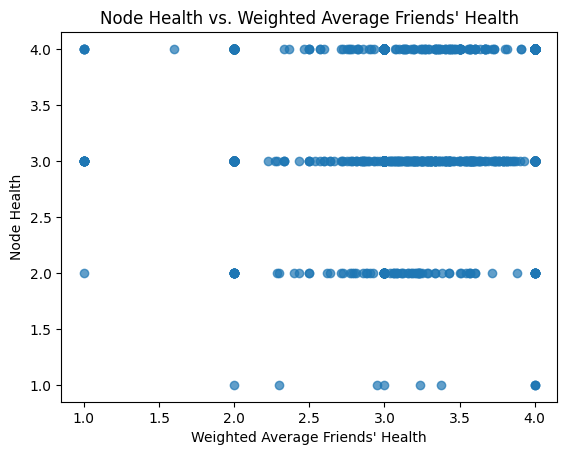

In [34]:
from scipy.stats import pearsonr

# Drop rows with missing data
health_df_cleaned = health_df.dropna()

# Correlation analysis
if not health_df_cleaned.empty:
    correlation, p_value = pearsonr(
        health_df_cleaned['health'],
        health_df_cleaned['weighted_avg_friends_health']
    )
    print(f"Pearson Correlation: {correlation:.2f}, p-value: {p_value:.2e}")

    # Plot the relationship
    plt.scatter(
        health_df_cleaned['weighted_avg_friends_health'],
        health_df_cleaned['health'],
        alpha=0.7
    )
    plt.title("Node Health vs. Weighted Average Friends' Health")
    plt.xlabel("Weighted Average Friends' Health")
    plt.ylabel("Node Health")
    plt.show()
else:
    print("No valid data for correlation analysis.")


In [35]:
import math

ego_health_analysis_unweighted = []

# Loop over all nodes to compute unweighted average health
for ego in G.nodes:
    # Get neighbors (friends) of the ego
    friends = [
        n for n in G.neighbors(ego)
        if 'health' in G.nodes[n] and G.nodes[n]['health'] is not None
    ]

    if friends:
        # Compute unweighted sum of friends' health
        total_health = sum(G.nodes[friend]['health'] for friend in friends)
        unweighted_avg_health = total_health / len(friends)  # Average health
    else:
        unweighted_avg_health = None

    # Ensure 'health' exists for the ego node before accessing it
    ego_health = G.nodes[ego]['health'] if 'health' in G.nodes[ego] else None

    # Append the result
    ego_health_analysis_unweighted.append({
        'node_id': ego,
        'health': ego_health,
        'unweighted_avg_friends_health': unweighted_avg_health
    })

# Convert results to a DataFrame for analysis
health_df_unweighted = pd.DataFrame(ego_health_analysis_unweighted)
print(health_df_unweighted)


       node_id  health  unweighted_avg_friends_health
0       983040     NaN                           3.00
1       786432     3.0                           3.00
2       524296     4.0                           3.50
3       327690     3.0                           3.00
4       917517     NaN                           2.25
...        ...     ...                            ...
15827   589796     NaN                           3.00
15828   655346     NaN                           4.00
15829   983033     NaN                            NaN
15830   851962     4.0                           3.00
15831    43522     NaN                            NaN

[15832 rows x 3 columns]


Pearson Correlation (Unweighted): 0.10, p-value: 4.57e-05


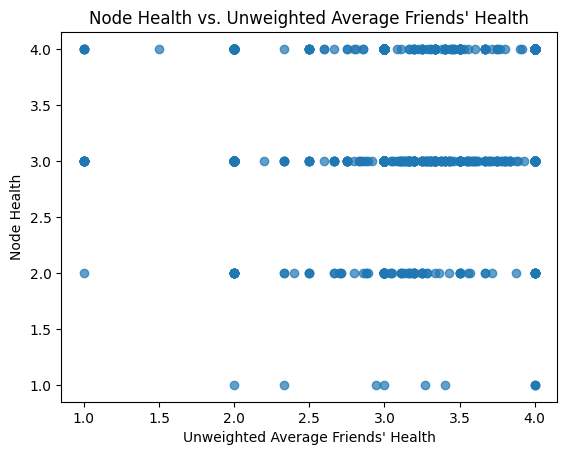

In [36]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Drop rows with missing data
health_df_unweighted_cleaned = health_df_unweighted.dropna()

# Correlation analysis
if not health_df_unweighted_cleaned.empty:
    correlation, p_value = pearsonr(
        health_df_unweighted_cleaned['health'],
        health_df_unweighted_cleaned['unweighted_avg_friends_health']
    )
    print(f"Pearson Correlation (Unweighted): {correlation:.2f}, p-value: {p_value:.2e}")

    # Scatterplot
    plt.scatter(
        health_df_unweighted_cleaned['unweighted_avg_friends_health'],
        health_df_unweighted_cleaned['health'],
        alpha=0.7
    )
    plt.title("Node Health vs. Unweighted Average Friends' Health")
    plt.xlabel("Unweighted Average Friends' Health")
    plt.ylabel("Node Health")
    plt.show()
else:
    print("No valid data for correlation analysis.")
